Pernahkah Anda memikirkan aplikasi yang dapat memprediksi apakah pinjaman Anda akan disetujui atau tidak? Pada artikel ini, kita akan mengembangkan salah satu model yang dapat memprediksi apakah seseorang akan mendapatkan pinjamannya disetujui atau tidak dengan menggunakan beberapa informasi latar belakang pemohon seperti jenis kelamin, status perkawinan, pendapatan, dll.

Langkah 1: Mengimpor Pustaka
Pada langkah ini, kita akan mengimpor perpustakaan seperti NumPy, Pandas, Matplotlib, dll

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')


Langkah 2: Memuat Himpunan Data

In [2]:
df = pd.read_csv('loan_data.csv')
df.head()


,Loan_ID,Gender,Married,ApplicantIncome,LoanAmount,Loan_Status
0,LP001002,Male,No,5849,NaN,Y
1,LP001003,Male,Yes,4583,128.0,N
2,LP001005,Male,Yes,3000,66.0,Y
3,LP001006,Male,Yes,2583,120.0,Y
4,LP001008,Male,No,6000,141.0,Y


In [3]:
# Melihat bentuk dataset
df.shape


(598, 6)

In [4]:
# Informasi dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Loan_ID          598 non-null    object 
 1   Gender           598 non-null    object 
 2   Married          598 non-null    object 
 3   ApplicantIncome  598 non-null    int64  
 4   LoanAmount       577 non-null    float64
 5   Loan_Status      598 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 28.2+ KB


In [5]:
# Statistik deskriptif
df.describe()


,ApplicantIncome,LoanAmount
count,598.000000,577.000000
mean,5292.252508,144.968804
std,5807.265364,82.704182
min,150.000000,9.000000
25%,2877.500000,100.000000
50%,3806.000000,127.000000
75%,5746.000000,167.000000
max,81000.000000,650.000000


Langkah 3: Analisis Data Eksplorasi (EDA)
Mari mulai dengan memplot diagram pai untuk kolom Loan_Status.

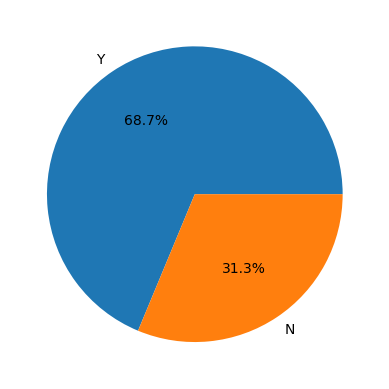

In [6]:
temp = df['Loan_Status'].value_counts()
plt.pie(temp.values, labels=temp.index, autopct='%1.1f%%')
plt.show()


Countplot Gender dan Married dengan hue Loan_Status

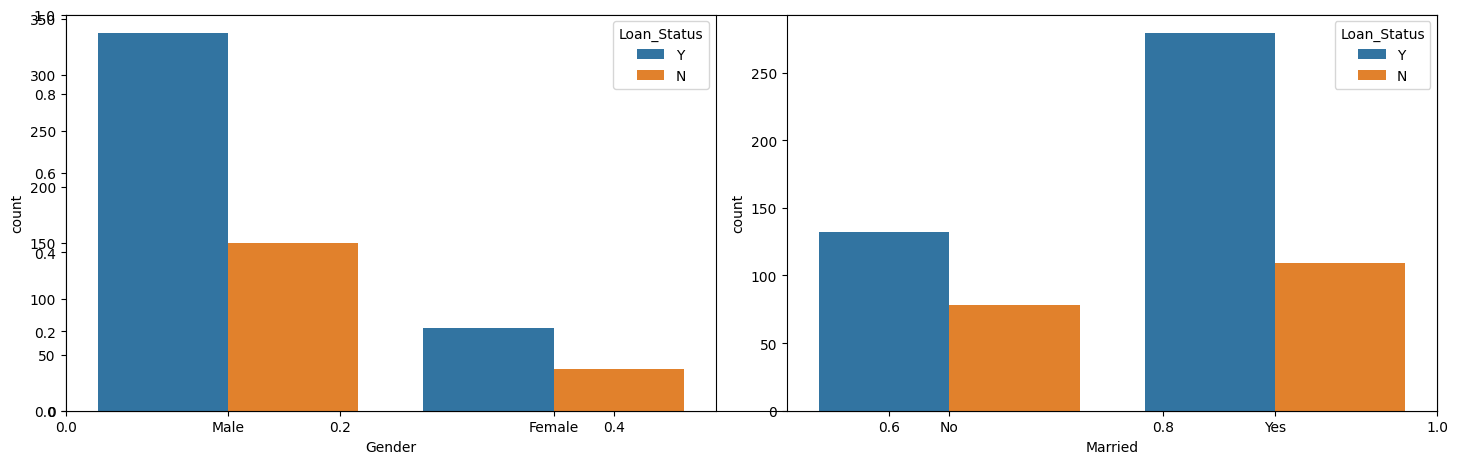

In [7]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['Gender', 'Married']):
    plt.subplot(1, 2, i+1)
    sb.countplot(data=df, x=col, hue='Loan_Status')
plt.tight_layout()
plt.show()


Distribusi ApplicantIncome dan LoanAmount

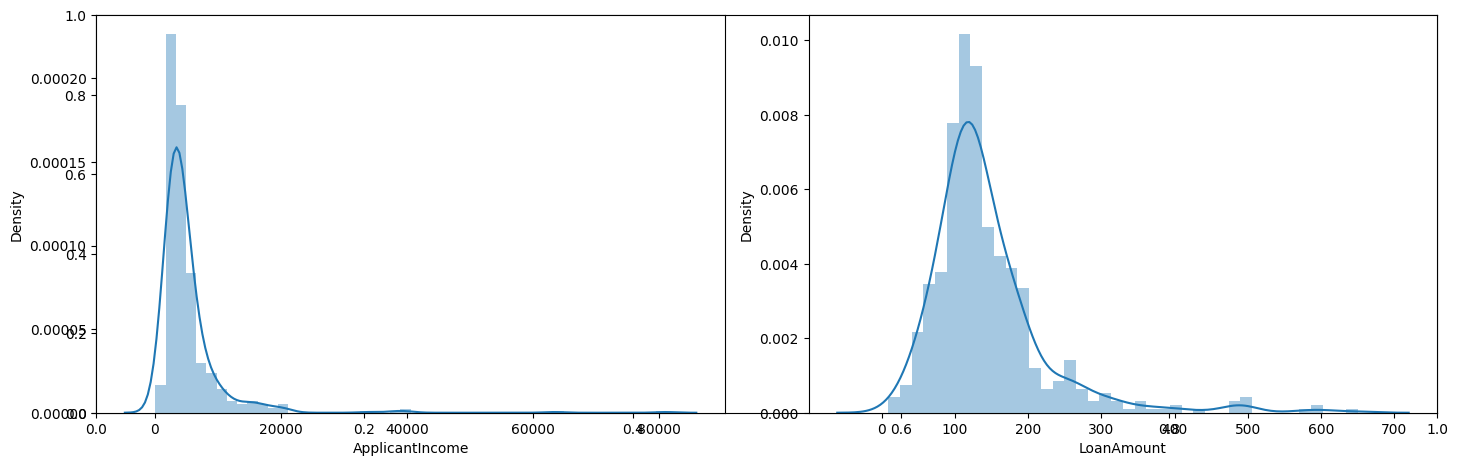

In [8]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['ApplicantIncome', 'LoanAmount']):
    plt.subplot(1, 2, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()


Boxplot untuk mendeteksi outlier

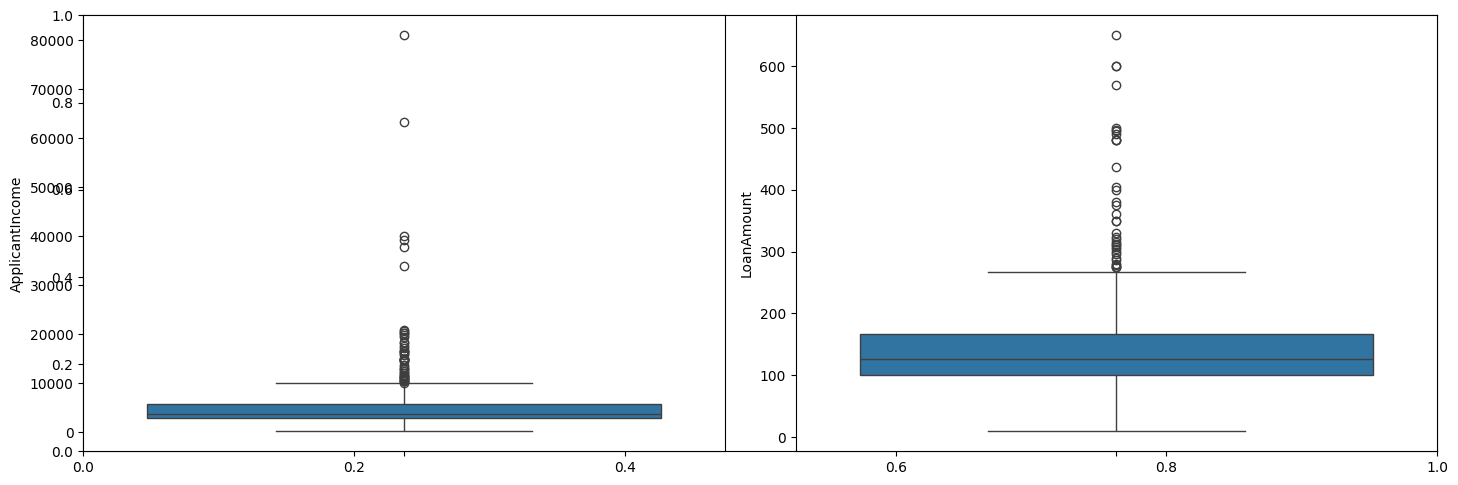

In [9]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['ApplicantIncome', 'LoanAmount']):
    plt.subplot(1, 2, i+1)
    sb.boxplot(df[col])
plt.tight_layout()
plt.show()


Menghapus outlier ekstrem

In [10]:
df = df[df['ApplicantIncome'] < 25000]
df = df[df['LoanAmount'] < 400000]


Rata-rata LoanAmount berdasarkan Gender dan kombinasi Married-Gender

In [11]:
df.groupby('Gender').mean(numeric_only=True)['LoanAmount']


Gender
Female    126.697248
Male      146.872294
Name: LoanAmount, dtype: float64

In [12]:
df.groupby(['Married', 'Gender']).mean(numeric_only=True)['LoanAmount']


Married  Gender
No       Female    116.115385
         Male      135.959677
Yes      Female    153.322581
         Male      150.875740
Name: LoanAmount, dtype: float64

Label Encoding untuk fitur kategorikal dan Heatmap korelasi

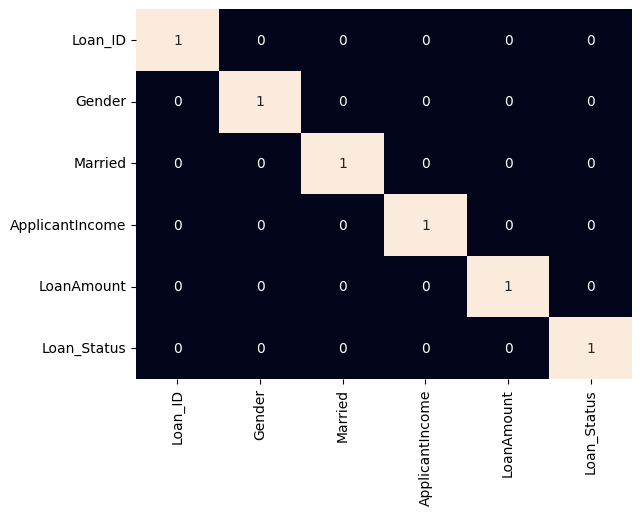

In [13]:
# Function to apply label encoding
def encode_labels(data):
    for col in data.columns:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
    return data

# Applying function in whole column
df = encode_labels(df)

# Generating Heatmap
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()


Langkah 4: Prapemrosesan Data
Membagi data train/validasi, menyeimbangkan kelas, dan normalisasi fitur.

In [14]:
features = df.drop('Loan_Status', axis=1)
target = df['Loan_Status'].values

X_train, X_val, Y_train, Y_val = train_test_split(
    features, target,
    test_size=0.2,
    random_state=10
)

# As the data was highly imbalanced we will balance
# it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)

X_train.shape, X.shape


((456, 5), (638, 5))

In [15]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)


Langkah 5: Pengembangan Model (Support Vector Classifier)

In [16]:
from sklearn.metrics import roc_auc_score
model = SVC(kernel='rbf')
model.fit(X, Y)
print('Training Accuracy : ', metrics.roc_auc_score(Y, model.predict(X)))
print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, model.predict(X_val)))
print()


Training Accuracy :  0.6300940438871474
Validation Accuracy :  0.48198198198198194



Step 6: Model Evaluation (Confusion Matrix, ROC AUC, Classification Report)

Training ROC AUC Score: 0.6300940438871474
Validation ROC AUC Score: 0.48198198198198194



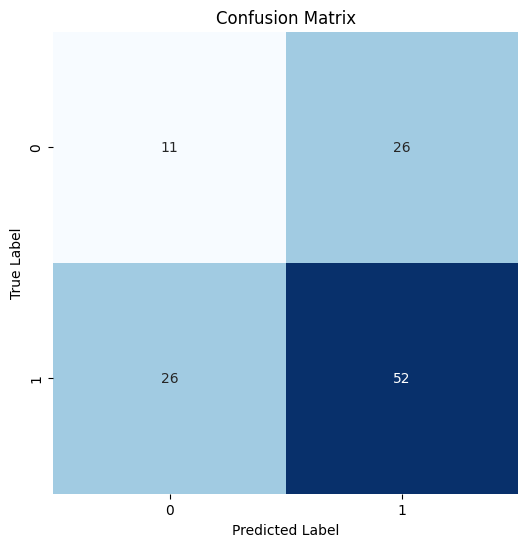

              precision    recall  f1-score   support

           0       0.30      0.30      0.30        37
           1       0.67      0.67      0.67        78

    accuracy                           0.55       115
   macro avg       0.48      0.48      0.48       115
weighted avg       0.55      0.55      0.55       115



In [17]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
training_roc_auc = roc_auc_score(Y, model.predict(X))
validation_roc_auc = roc_auc_score(Y_val, model.predict(X_val))
print('Training ROC AUC Score:', training_roc_auc)
print('Validation ROC AUC Score:', validation_roc_auc)
print()
cm = confusion_matrix(Y_val, model.predict(X_val))
plt.figure(figsize=(6, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(Y_val, model.predict(X_val)))
